In [1]:
import pyspark as ps
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, Tokenizer, OneHotEncoder, StringIndexer, VectorAssembler
import bleach
from pyspark.sql.functions import *

spark = (
        ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("lecture") 
        .getOrCreate()
        )

sc = spark.sparkContext

In [2]:
# read CSV
tw_txt = spark.read.csv('clean_tweets',
                         header=True)  

tw_txt.show(5)

+---+----------+------------+--------------------+-----+
|_c0|Unnamed: 0|Unnamed: 0.1|                text|label|
+---+----------+------------+--------------------+-----+
|  0|         0|           0|RT @morningJewsho...|    0|
|  1|         1|           1|This age/face rec...|    0|
|  2|         2|           2|Only upside of th...|    0|
|  3|         3|           3|If you're going t...|    0|
|  4|         4|           4|Watching a thread...|    0|
+---+----------+------------+--------------------+-----+
only showing top 5 rows



In [3]:
type(tw_txt)

pyspark.sql.dataframe.DataFrame

In [13]:
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
tokens = tokenizer.transform(tw_txt)
tokens.show(5)

+---+----------+------------+--------------------+-----+--------------------+
|_c0|Unnamed: 0|Unnamed: 0.1|                text|label|              tokens|
+---+----------+------------+--------------------+-----+--------------------+
|  0|         0|           0|RT @morningJewsho...|    0|[rt, @morningjews...|
|  1|         1|           1|This age/face rec...|    0|[this, age/face, ...|
|  2|         2|           2|Only upside of th...|    0|[only, upside, of...|
|  3|         3|           3|If you're going t...|    0|[if, you're, goin...|
|  4|         4|           4|Watching a thread...|    0|[watching, a, thr...|
+---+----------+------------+--------------------+-----+--------------------+
only showing top 5 rows



In [18]:
tokens.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Unnamed: 0: string (nullable = true)
 |-- Unnamed: 0.1: string (nullable = true)
 |-- text: string (nullable = true)
 |-- label: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [19]:
tokens.withColumn("label", tokens['label'].cast(IntegerType()))

DataFrame[_c0: string, Unnamed: 0: string, Unnamed: 0.1: string, text: string, label: int, tokens: array<string>]

In [22]:
cv = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=50)
cv_model = cv.fit(tokens)
cv_df = cv_model.transform(tokens)
cv_df.show(5)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:56075)
Traceback (most recent call last):
  File "/usr/local/Cellar/apache-spark/2.4.0/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/Cellar/apache-spark/2.4.0/libexec/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:56075)

In [ ]:
# type(cv_df)

In [17]:
cv_df = cv_df.withColumn("label", cv_df["label"].cast(IntegerType()))

In [18]:
cv_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Unnamed: 0: string (nullable = true)
 |-- Unnamed: 0.1: string (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)



In [19]:
cv_df.select('words',col('Features').alias('Features(vocab_size,[index],[tf])')).show(truncate=False)
print("Vocabulary from CountVectorizerModel is" + str(cv_model.vocabulary))

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------+
|words                                                                                                                                                                    |Features(vocab_size,[index],[tf])                |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------+
|[rt, @morningjewshow:, speaking, about, jews, and, comedy, tonight, at, temple, emanu-el, in, san, francisco., in, other, words,, my, high, holidays.]                   |(50,[2,7,16,20,40],[1.0,2.0,1.0,1.0,1.0])        |
|[this, age/face, recognition, thing..no, reason, platforms, can't, have, changing, avatars, of, our, actual, fa

In [ ]:
# print(cv_df.select('features').take(5)[3]['features'])

In [11]:
rescaledData = rescaledData.sample(fraction=0.1)

In [12]:
train_df, test_df = rescaledData.randomSplit([0.7, 0.3], seed = 24)

In [13]:
train_df.show(5)

+-------+----------+--------------------+-----+--------------------+--------------------+--------------------+
|    _c0|Unnamed: 0|                text|label|              tokens|         rawFeatures|            features|
+-------+----------+--------------------+-----+--------------------+--------------------+--------------------+
|1000001|   1000001|RT @JoshIshmaelca...|    0|[rt, @joshishmael...|(20,[1,3,5,6,7,8,...|(20,[1,3,5,6,7,8,...|
|1000023|   1000023|"RT @ShawnMichael...|    0|["rt, @shawnmicha...|(20,[0,1,3,5,6,9,...|(20,[0,1,3,5,6,9,...|
|1000050|   1000050|RT @MRAHunting: #...|    0|[rt, @mrahunting:...|(20,[0,2,6,9,10,1...|(20,[0,2,6,9,10,1...|
|1000051|   1000051|Watching Father's...|    0|[watching, father...|(20,[2,3,5,9,10,1...|(20,[2,3,5,9,10,1...|
|1000075|   1000075|RT @shanneeei: Ch...|    0|[rt, @shanneeei:,...|(20,[0,1,2,3,4,5,...|(20,[0,1,2,3,4,5,...|
+-------+----------+--------------------+-----+--------------------+--------------------+--------------------+
o

In [14]:
train_df = train_df.withColumn("label", train_df['label'].cast(IntegerType()))

In [15]:
train_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Unnamed: 0: string (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- rawFeatures: vector (nullable = true)
 |-- features: vector (nullable = true)



In [16]:
train_df.count()

311889

In [17]:
import missingno as ms

In [18]:
train_df = train_df.toPandas()

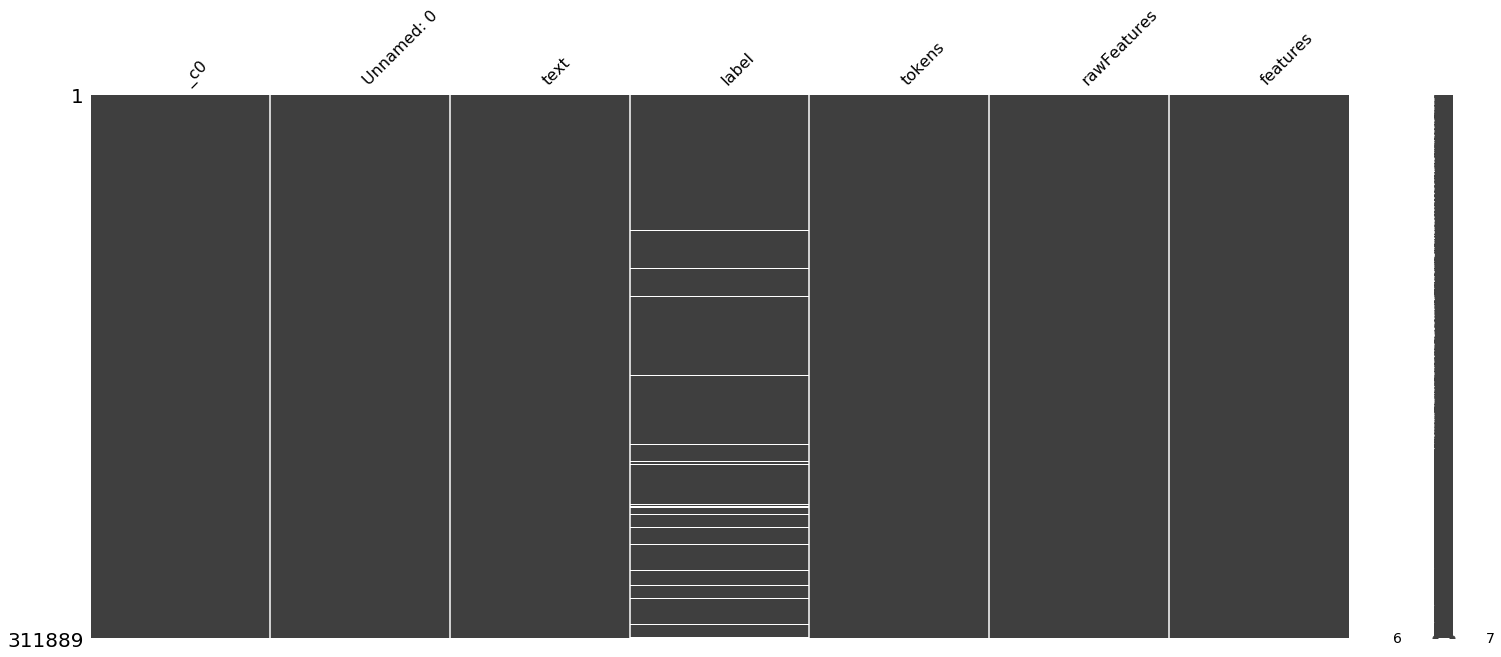

In [19]:
ms.matrix(train_df)

In [20]:
train_df.isna().sum()

_c0               0
Unnamed: 0        0
text              0
label          9082
tokens            0
rawFeatures       0
features          0
dtype: int64

In [21]:
train_df.dropna(inplace=True)

In [22]:
from pyspark.ml.classification import NaiveBayes

In [23]:
train_df = spark.createDataFrame(train_df)

In [24]:
nb = NaiveBayes()
model = nb.fit(train_df)

In [25]:
predictions = model.transform(test_df)

In [31]:
predictions.show(5)

+-------+----------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    _c0|Unnamed: 0|                text|label|              tokens|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+-------+----------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    100|       100|@ElisaC I was (st...|    0|[@elisac, i, was,...|(20,[0,1,3,4,5,6,...|(20,[0,1,3,4,5,6,...|[-62.097126352628...|[0.76136900756694...|       0.0|
| 100000|    100000|#DeCalle13Aprendi...|    0|[#decalle13aprend...|(20,[1,3,4,8,12,1...|(20,[1,3,4,8,12,1...|[-29.079550055515...|[0.70351916782561...|       0.0|
|1000002|   1000002|Just saw @ShawnMi...|    0|[just, saw, @shaw...|(20,[0,2,7,8,10,1...|(20,[0,2,7,8,10,1...|[-51.778589003846...|[0.80915806630158...|       0.0|
|1000034|   1000

In [26]:
predictions.filter(predictions['prediction'] == 0) \
    .select("text","label","probability","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-----+------------------------------+----------+
|                          text|label|                   probability|prediction|
+------------------------------+-----+------------------------------+----------+
|@sassyfivesos well I went t...|    0|[0.9995508166613992,4.48717...|       0.0|
|RT @the1975: // A U C K L A...|    0|[0.9995264211220555,4.73578...|       0.0|
|The album is 9 songs, 4 son...|    0|[0.9994050835327888,5.94900...|       0.0|
|Sadly, they teach us to hol...|    0|[0.9991505527920154,8.49446...|       0.0|
|#RT  . . . . . . Per . . . ...|    1|[0.9989978528990597,1.94393...|       0.0|
|RT @ItsJ_Cole: So Many Peop...|    0|[0.9989910027956683,0.00100...|       0.0|
|RT @LauraHullLMFT: U can ch...|    0|[0.9989685011067748,0.00103...|       0.0|
|RT @FreakingTrue: Me: I'm g...|    0|[0.9988206878787147,0.00117...|       0.0|
|I'm directly going to suck ...|    0|[0.9987072944011584,0.00129...|       0.0|
|What I'm looking for cannot

In [32]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [33]:
predictions = predictions.withColumn("label", predictions['label'].cast(IntegerType()))

In [35]:
type(predictions)

pyspark.sql.dataframe.DataFrame

In [34]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

Py4JJavaError: An error occurred while calling o325.evaluate.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 18.0 failed 1 times, most recent failure: Lost task 3.0 in stage 18.0 (TID 41, localhost, executor driver): scala.MatchError: [0.0,null] (of class org.apache.spark.sql.catalyst.expressions.GenericRowWithSchema)
	at org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator$$anonfun$1.apply(MulticlassClassificationEvaluator.scala:79)
	at org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator$$anonfun$1.apply(MulticlassClassificationEvaluator.scala:79)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:193)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:62)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$countByKey$1.apply(PairRDDFunctions.scala:370)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$countByKey$1.apply(PairRDDFunctions.scala:370)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.PairRDDFunctions.countByKey(PairRDDFunctions.scala:369)
	at org.apache.spark.rdd.RDD$$anonfun$countByValue$1.apply(RDD.scala:1214)
	at org.apache.spark.rdd.RDD$$anonfun$countByValue$1.apply(RDD.scala:1214)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.countByValue(RDD.scala:1213)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labelCountByClass$lzycompute(MulticlassMetrics.scala:42)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labelCountByClass(MulticlassMetrics.scala:42)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.weightedFMeasure$lzycompute(MulticlassMetrics.scala:215)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.weightedFMeasure(MulticlassMetrics.scala:215)
	at org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator.evaluate(MulticlassClassificationEvaluator.scala:84)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: scala.MatchError: [0.0,null] (of class org.apache.spark.sql.catalyst.expressions.GenericRowWithSchema)
	at org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator$$anonfun$1.apply(MulticlassClassificationEvaluator.scala:79)
	at org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator$$anonfun$1.apply(MulticlassClassificationEvaluator.scala:79)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:193)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:62)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [ ]:
# Below is my original code to LR before deciding maybe I was asking too much
# lr = LogisticRegression(maxIter=10, 
#                         regParam=0.001, 
#                         featuresCol='features',
#                         labelCol='label',
#                         predictionCol='prediction',
#                         probabilityCol='probability'

In [ ]:
# pipeline = Pipeline()
# allData = pipeline.fit(tw_txt).transform(tw_txt)
# allData.cache()
# trainingData, testData = allData.randomSplit([0.8,0.2], seed=0) # need to ensure same split for each time
# print("Distribution of 1 and 0 in trainingData is: ", trainingData.groupBy("label").count().take(3))